# Finite element method: Generalized Poisson equation in 1D

Consider the Problem 
$$
\begin{aligned}
-(c(x) u'(x))' &= f(x) &\text{in } \Omega = (0,1) \\
u(0) = u(1) &= 0
\end{aligned}
$$
with $c(x) \geq \alpha > 0$ for all $x \in \Omega$.

Solve the problem using piecewise linear finite elements on a equidistant grid with mesh size $h > 0$.
To study the convergence rate of this method, calculate the numerical error w.r.t. the $L^2$ and $H^1$ norm.

Test the implementation for the case $c(x) = -x^2 + x + 1$ with the exact solution $u(x) = \frac{1}{\pi} \sin(\pi x)$. Plot the exact and numerical solution for $h = 0.2, 0.1, 0.05$, as well as the error on a logarithmic scale.

Finally consider
$$
\begin{align*}
c(x) &= \begin{cases} 1 \; , & 0 < x \leq \frac 1 2 \\ 4 \; , & \text{else} \end{cases} \\
f(x) &= \begin{cases} 5 \; , & 0.2 < x \leq 0.4 \\ 0 \; , & \text{else} \end{cases}
\end{align*}
$$
Plot the numerical solution for $h = 0.02$. What do you observe?

## Solution

The assembly process of the load vector is the same as in the previous exercise.
The element stiffness matrices are given by 

$$
(A_K)_{i,j} = \frac{2}{h} \int_{-1}^1 c(F_K(\xi)) N_i'(\xi) N_j'(\xi) \; \mathrm d\xi \; .
$$
These integrals are calculated with the Simpson rule.

We first write a function that implements the Simpson rule, and afterwards, functions to assembly the stiffness matrix and the load vector.

In [1]:
function simpson(f, a, b)
    (b - a) / 6 * (f(a) + 4*f((a+b)/2) + f(b))
end
;

In [2]:
using SparseArrays
function assembly_stiffness_matrix(h, c)
    x = 0:h:1
    nelements = length(x) - 1
    Ael = [0.0 0.0; 0.0 0.0]
    A = spzeros(nelements + 1, nelements + 1)
    for el in 1:nelements
        m = (x[el] + x[el+1])/2
        f0(xi) = c(m + xi * h/2) * 0.25
        f1(xi) = -c(m + xi * h/2) * 0.25
        Ael[1,1] = Ael[2,2] = 2 / h * simpson(f0, -1, 1)
        Ael[1,2] = Ael[2,1] = 2 / h * simpson(f1, -1, 1)
        A[el:el+1, el:el+1] += Ael
    end
    
    # Dirichlet boundary conditions:
    A[1,1] = 1
    A[1,2] = 0
    A[end, end] = 1
    A[end, end-1] = 0
    A
end
;

In [3]:
function assembly_load_vector(h, f)
    x = 0:h:1
    nelements = length(x) - 1
    lel = [0.0, 0.0]
    l = zeros(nelements + 1)
    for el in 1:nelements
        m = (x[el] + x[el+1]) / 2
        f0(xi) = (1 - xi) / 2 * f(m + xi * h/2)
        f1(xi) = (1 + xi) / 2 * f(m + xi * h/2)
        lel[1] = h / 2 * simpson(f0, -1, 1)
        lel[2] = h / 2 * simpson(f1, -1, 1)
        l[el:el+1] += lel
    end
    
    # Dirichlet boundary conditions:
    l[1] = l[end] = 0
    l
end
;

In [4]:
function solve(h, c, f)
    A = assembly_stiffness_matrix(h, c)
    l = assembly_load_vector(h, f)
    A \ l
end
;

We now test our implementation for the case $c(x) = -x^2 + x + 1$ and the exact solution $u(x) = \frac{1}{\pi} \sin(\pi x)$ for the mesh sizes $h = 0.2, 0.1, 0.05$.

We calculate 
$$
f(x) = (2x-1) \cos(\pi x) + \pi (-x^2 + x + 1) \sin(\pi x) \; .
$$

In [5]:
f(x) = (2x - 1) .* cos.(pi*x) + pi * (-x.^2 + x + 1) .* sin.(pi*x);

In [6]:
c(x) = -x.^2 + x + 1;

In [7]:
mesh_sizes = [0.2, 0.1, 0.05]
numerical_solutions = [solve(h, c, f) for h in mesh_sizes]

3-element Array{Array{Float64,1},1}:
 [0.0, 0.186558, 0.30159, 0.30159, 0.186558, 0.0]                                                                                                                                                   
 [0.0, 0.0983259, 0.186985, 0.257326, 0.30248, 0.318038, 0.30248, 0.257326, 0.186985, 0.0983259, 0.0]                                                                                               
 [0.0, 0.0497922, 0.0983546, 0.144493, 0.187071, 0.225042, 0.257472, 0.283562, 0.30267, 0.314327  …  0.314327, 0.30267, 0.283562, 0.257472, 0.225042, 0.187071, 0.144493, 0.0983546, 0.0497922, 0.0]

In [8]:
using PyPlot
function plot_numerical(numsol, exact=true, nline="-o")
    if exact
        u(x) = 1 / pi * sin.(pi * x)
        x_exact = 0:0.01:1
        plot(x_exact, u(x_exact))
    end
    
    h = 1/(length(numsol) - 1)
    x = 0:h:1
    
    plot(x, numsol, nline)
    xlabel("x")
    
    if exact
        legend(("exact", "numerical"))
        title(string("Exact and numerical solution for h = ", h))
    else
        title(string("Numerical solution for h = ", h))
    end  
end
;

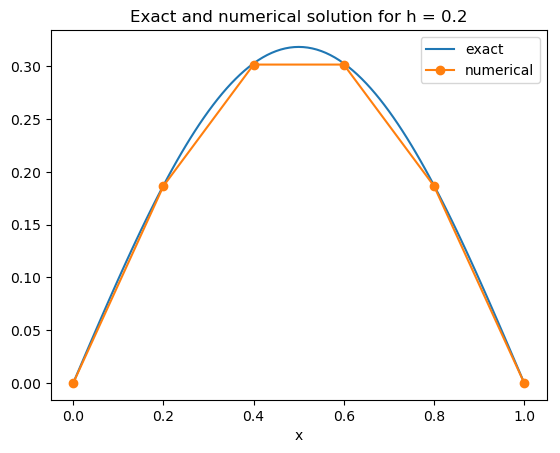

In [9]:
plot_numerical(numerical_solutions[1]);

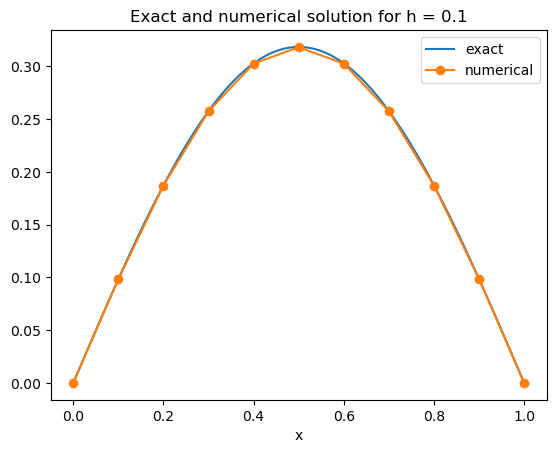

In [10]:
plot_numerical(numerical_solutions[2]);

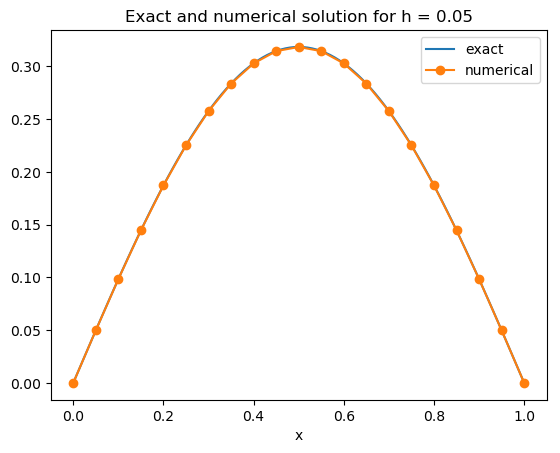

In [11]:
plot_numerical(numerical_solutions[3]);

We implement a function, which gives as the $L^2$ and $H^1$ error of a numerical solution.

In [12]:
function l2h1error(numsol, u, udx)
    h = 1/(length(numsol) - 1)
    x = 0:h:1
    
    l2square = 0.0
    h1square_half = 0.0
    
    for i = 1:length(numsol) - 1
        m = x[i] + h / 2
        mval = (numsol[i] + numsol[i+1])/2
        l2square += h / 6 * ((u(x[i]) - numsol[i])^2 + 4 * (u(m) - mval)^2 + (u(x[i+1]) - numsol[i+1])^2)
        uhdx = (numsol[i+1] - numsol[i]) / h
        h1square_half += h / 6 * ((udx(x[i]) - uhdx)^2 + 4 * (udx(m) - uhdx)^2 + (udx(x[i+1]) - uhdx)^2)
    end
    return (sqrt(l2square), sqrt(l2square + h1square_half))
    
end
;

In [13]:
l2h1errors = [l2h1error(numsol, x->1/pi*sin.(pi*x), x->cos.(pi*x)) for numsol in numerical_solutions]

3-element Array{Tuple{Float64,Float64},1}:
 (0.009621837566147632, 0.12759589157151835)  
 (0.0024032952755368387, 0.0640436472561822)  
 (0.0006006764579702359, 0.032053222873670524)

In [14]:
l2errors = [er[1] for er in l2h1errors]
h1errors = [er[2] for er in l2h1errors];

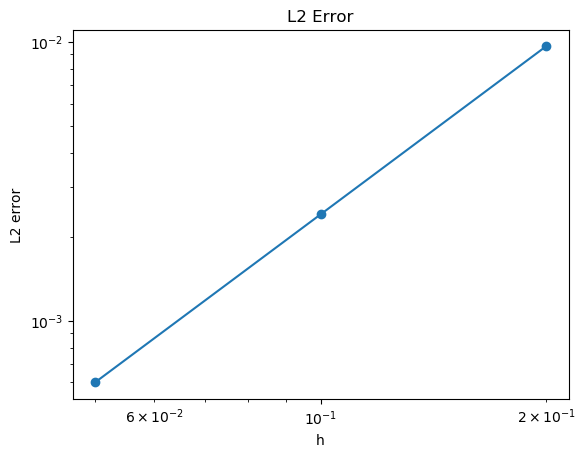

In [15]:
loglog(mesh_sizes, l2errors, "o-")
title("L2 Error")
xlabel("h")
ylabel("L2 error");

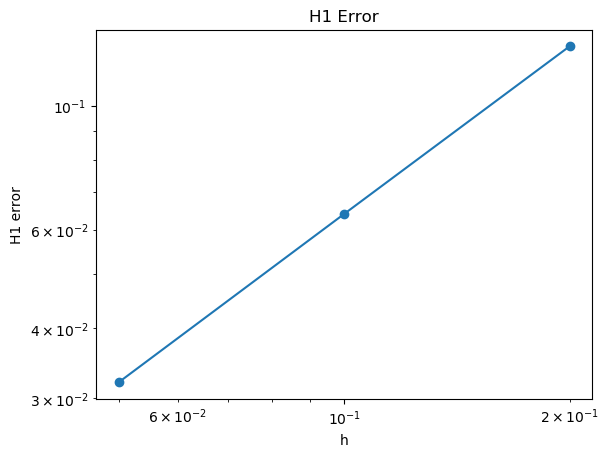

In [16]:
loglog(mesh_sizes, h1errors, "o-")
title("H1 Error")
xlabel("h")
ylabel("H1 error");

Finally, we use $c$ and $f$ as in the assignment description and plot the solution for $h = 0.02$

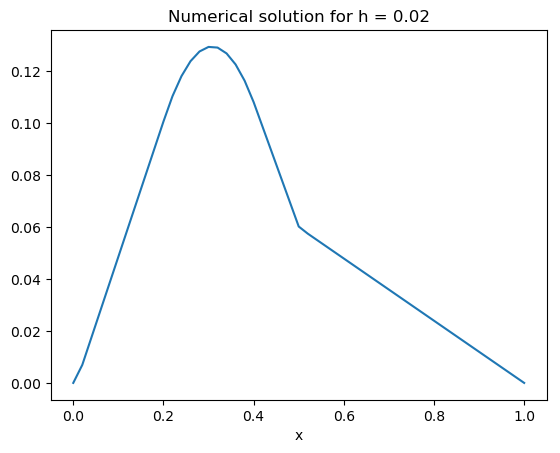

In [17]:
c(x) = (x .> 0 && x .<= 0.5) ? 1 : 4
f(x) = (x .> 0.2 && x .<= 0.4) ? 5 : 0
h = 0.02
numsol = solve(h, c, f)
plot_numerical(numsol, false, "-");